# 1

## a

For any real $y$, 
$$
P(Y \leq y) = P(X_1 \leq y, \dots, X_n \leq y)
$$
Because $X_1,\dots,X_n$ are iid, we have:
$$
F_Y(y)=P(Y \leq y) = \prod_{i=1}^nP(X_i \leq y) = (F(y))^n
$$
Thus, when the false positive rate when $Y > c$ is:
$$
P(Y > c) = 1 - P(Y \leq c) = 1 - (F(c))^n
$$
To control this at level $\alpha$, we need:
$$
1 - (F(c))^n = \alpha \\
F(c) = (1 - \alpha)^{1/n} \\
c = F^{-1}((1 - \alpha)^{1/n})
$$

### i
When $X_i \sim \mathcal{N}(\mu, \sigma^2)$:
$$
F(x) = \Phi\left(\frac{x - \mu}{\sigma}\right), \therefore \\
\Phi\left(\frac{x - \mu}{\sigma}\right) = (1 - \alpha)^{1/n} \\
\frac{x - \mu}{\sigma} = \Phi^{-1}((1 - \alpha)^{1/n}) \\
c = \mu + \sigma\Phi^{-1}((1 - \alpha)^{1/n})
$$

### ii
When $X_i \sim \text{Exp}(\mu)$, which implies $\lambda = 1/\mu$:
$$
F(x) = \begin{cases}
    0, &  x < 0 \\
    1 - e^{-x/\mu}, & x \geq 0
\end{cases}
$$
But realistically, a threshold for $c$ is always going to be $\geq 0$, so:
$$
1 - e^{-c/\mu} = (1 - \alpha)^{1/n} \\
e^{-c/\mu} = 1 - (1 - \alpha)^{1/n} \\
c = -\mu\ln(1 - (1 - \alpha)^{1/n})
$$

## b

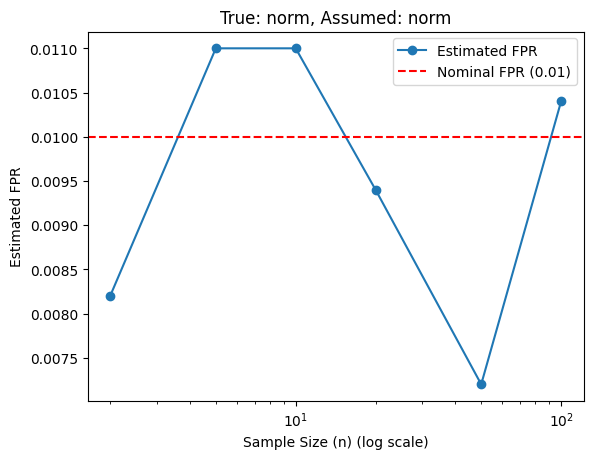

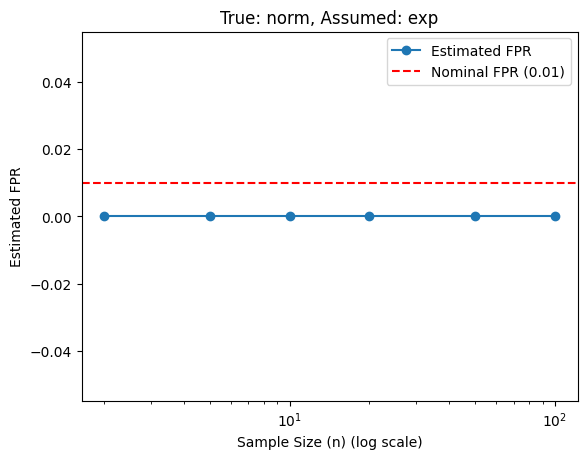

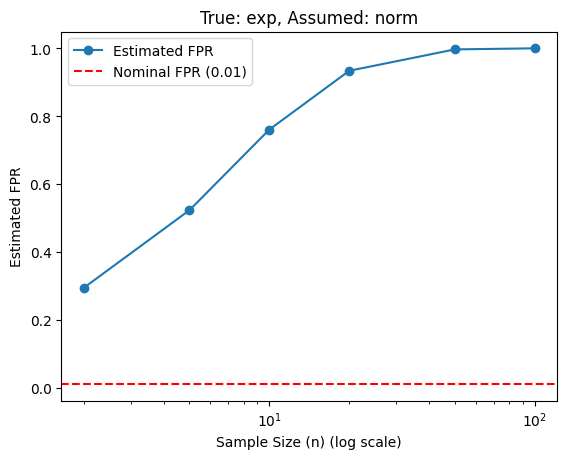

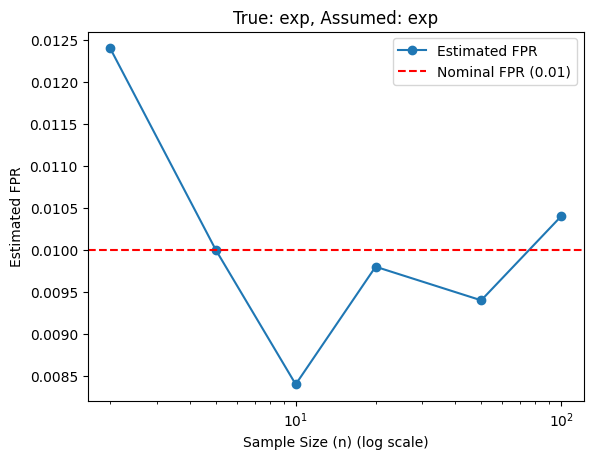

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

alpha = 0.01
mu = 1.5
sigma = 0.5
n_values = [2, 5, 10, 20, 50, 100]
N = 5000

rng = np.random.default_rng(seed=0)

def threshold_normal(alpha, n, mu, sigma):
    q = (1 - alpha)**(1/n)
    return mu + sigma * norm.ppf(q)

def threshold_exp(alpha, n, mu):
    q = (1 - alpha)**(1/n)
    return -mu * np.log(1 - q)

def simulate_fpr(true_dist, assumed_dist):
    fprs = []
    for n in n_values:
        if assumed_dist == "norm":
            c = threshold_normal(alpha, n, mu, sigma)
        elif assumed_dist == "exp":
            c = threshold_exp(alpha, n, mu)
        
        if true_dist == "norm":
            X = rng.normal(loc=mu, scale=sigma, size=(N, n))
        elif true_dist == "exp":
            X = rng.exponential(scale=mu, size=(N, n))
    
        Y = X.max(axis=1)
        alpha_hat = np.mean(Y > c)
        fprs.append(alpha_hat)
    return fprs

scenarios = [
    ("norm", "norm"),
    ("norm", "exp"),
    ("exp", "norm"),
    ("exp", "exp")
]

for scenario in scenarios:
    true_dist, assumed_dist = scenario
    fprs = simulate_fpr(true_dist, assumed_dist)
    plt.plot(n_values, fprs, marker='o', label='Estimated FPR')
    plt.axhline(y=alpha, color='r', linestyle='--', label='Nominal FPR (0.01)')
    plt.xscale('log')
    plt.xlabel('Sample Size (n) (log scale)')
    plt.ylabel('Estimated FPR')
    plt.title(f'True: {true_dist}, Assumed: {assumed_dist}')
    plt.legend()
    plt.show()

i. Because the true distribution matches the assumed distribution, the estimated
FPR matches very closely to the true expected FPR.  
ii. The true distribution does not match the assumed distribution. The threshold
$c$ ends up so large that $P(Y > c)$ is practically 0 at $N = 5000$, thus we see
that $\hat{\alpha}$ is basically 0 across all $n$.  
iii. Again, the true distribution does not match the assuemd distribution. However
in this case, the threshold $c$ now becomes way too small for exponential tails, 
and thus $Y = max$ gets larger as $n$ grows, and the FPR explodes towards 1.  
iv. Here we return to the case where the true distribution matches the assumed
distribution, thus the estimated FPR fluctuates around the expected $\hat{\alpha}$.

## c

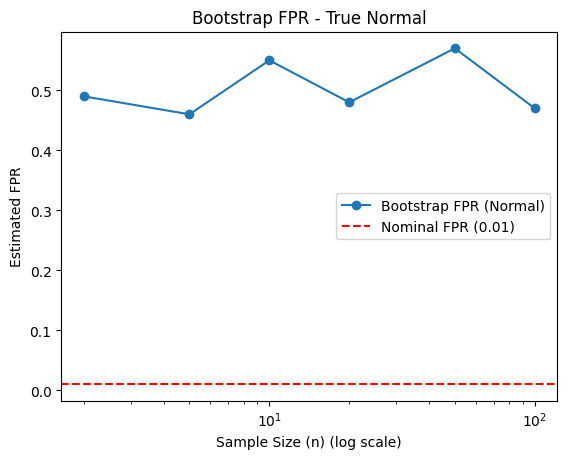

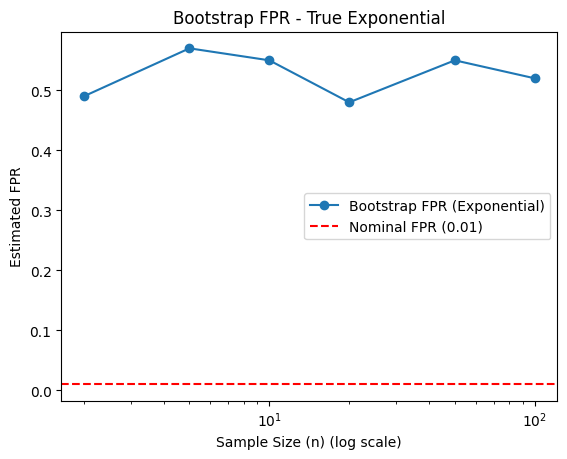

In [23]:
rng = np.random.default_rng(seed=0)

def bootstrap_threshold(x, alpha):
    x_sorted = np.sort(x)
    n = x_sorted.size
    target = 1 - alpha
    k = int(np.ceil(n * (target ** (1/n))))
    k = min(max(k, 1), n)
    return x_sorted[k - 1], k

def simulate_bootstrap_fpr(true_dist):
    fprs = []
    mean_c_boot = []
    mean_c_true = []
    mean_k = []

    for n in n_values:
        if true_dist == "norm":
            c_true = threshold_normal(alpha, n, mu, sigma)
        elif true_dist == "exp":
            c_true = threshold_exp(alpha, n, mu)

        if true_dist == "norm":
            X_train = rng.normal(loc=mu, scale=sigma, size=(N, n))
            X_test = rng.normal(loc=mu, scale=sigma, size=(N, n))
        elif true_dist == "exp":
            X_train = rng.exponential(scale=mu, size=(N, n))
            X_test = rng.exponential(scale=mu, size=(N, n))
        
        c_boot = np.empty(N)
        ks = np.empty(N, dtype=int)
        for i in range(N):
            c_boot[i], ks[i] = bootstrap_threshold(X_train[i], alpha)

        Y_test = X_test.max(axis=1)
        hat_alpha = np.mean(Y_test > c_boot)
        fprs.append(hat_alpha)
        mean_c_boot.append(np.mean(c_boot))
        mean_c_true.append(c_true)
        mean_k.append(np.mean(ks))
    
    return fprs, mean_c_boot, mean_c_true, mean_k

hat_norm, cboot_norm, ctrue_norm, k_norm = simulate_bootstrap_fpr("norm")
hat_exp, cboot_exp, ctrue_exp, k_exp = simulate_bootstrap_fpr("exp")

plt.plot(n_values, hat_norm, marker='o', label='Bootstrap FPR (Normal)')
plt.axhline(y=alpha, color='r', linestyle='--', label='Nominal FPR (0.01)')
plt.xscale('log')
plt.xlabel('Sample Size (n) (log scale)')
plt.ylabel('Estimated FPR')
plt.title('Bootstrap FPR - True Normal')
plt.legend()
plt.show()

plt.plot(n_values, hat_exp, marker='o', label='Bootstrap FPR (Exponential)')
plt.axhline(y=alpha, color='r', linestyle='--', label='Nominal FPR (0.01)')
plt.xscale('log')
plt.xlabel('Sample Size (n) (log scale)')
plt.ylabel('Estimated FPR')
plt.title('Bootstrap FPR - True Exponential')
plt.legend()
plt.show()

The bootstrap thresholds are terrible compared to the theoretical thresholds
from part (b). This is because the bootstrap can't generate values beyond 
what we have observed on a calm day, thus for any extreme tailed threshold
of 0.01, the bootstrap "thinks" the tail ends at our sample max, and thus
picks a threshold way too small for any true future maxima in a stormy day. Both
FPRs no matter the true distribution always end up around 0.5. We can explain
this mathematically, as given a calm day sample $x_1, \dots, x_n$, let $x_{(1)} \leq \dots \leq x_{(n)}$.
Then, the max of a bootstrap resample has CDF of $(\frac{k}{n})^n$, thus the bootstrap
$(1 - \alpha)$ quantile is the order statistic $\hat{c} = x_{(k)}$, where $k = n(1-\alpha)^{1/n}$.
For an $\alpha$ of $0.01$, $n = k$ which is the sample max, so the threshold 
becomes the calm-day sample maximum. Because our bootstrap threshold is the calm-day
maximum, then the next-day maximum is equally likely to be bigger or smaller since
they are the iid maxima from the same distribution. For continuous distributions, 
this probability is around 0.5, thus we see our estimated FPR of 0.5 in the Monte
Carlo simulations.

# 2

## a
Since $(X, Y)$ is bivariate normal, we have:
$$ 
E[X] = E[Y] = 0, \quad Var(X) = Var(Y) = 1, \quad Corr(X, Y) = \rho
$$
Thus, for the conditional distribution $Y | X$:
$$
E[Y | X = x] = \rho x, \quad Var(Y | x = x) = 1 - \rho^2, \quad \therefore \\
Y | X = x \sim \mathcal{N}(\rho x, 1 - \rho^2)
$$.
For conditional distribution $\tilde{Y} | X$, $X = x$ is Bernoulli with probability:
$$
p(x) = P(\tilde{Y} = 1 | X = x) = P(Y \geq c | X = x) \therefore \\
P(Y \geq c | X = x) = 1 - P(Y \leq c | x = x) = 1 - \Phi\left(\frac{c - \rho x}{\sqrt{1 - \rho^2}}\right) \therefore \\
\tilde{Y} | X = x \sim \text{Bernoulli}\left(\Phi\left(\frac{\rho x - c}{\sqrt{1 - \rho^2}}\right)\right)
$$

## b

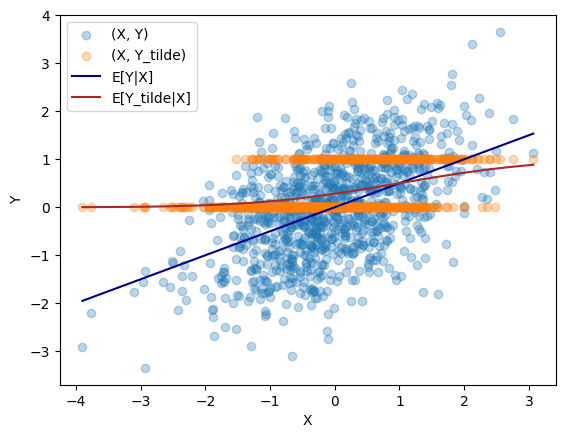

In [24]:
rho = 0.5
c = 0.5
n = 1000

rng = np.random.default_rng(seed=0)

X = rng.normal(size=n)
eps = rng.normal(size=n)
Y = rho * X + np.sqrt(1 - rho**2) * eps

Y_tilde = (Y >= c).astype(int)

x_grid = np.linspace(X.min(), X.max(), 100)
E_Y_given_X = rho * x_grid
E_Y_tilde_given_X = norm.cdf((rho * x_grid - c) / np.sqrt(1 - rho**2))

plt.scatter(X, Y, alpha=0.3, label="(X, Y)")
plt.scatter(X, Y_tilde, alpha=0.3, label="(X, Y_tilde)")
plt.plot(x_grid, E_Y_given_X, label="E[Y|X]", color="darkblue")
plt.plot(x_grid, E_Y_tilde_given_X, label="E[Y_tilde|X]", color="brown")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

As expected, we see a cloud of continous points representing $(X_i, Y_i)$. Likewise,
we see the expected two lines of the binary response $(X_i, \tilde{Y}_i)$. As
we previously calculated, $E[Y | X] = 0.5x$, which shows as a straight line, and
the slightly curved line is $E[\tilde{Y} | X] = \Phi\left(\frac{\rho x - c}{\sqrt{1 - \rho^2}}\right)$.
The continuous CEF is linear because of joint normality, while the binary CEF is
nonlinear since we are thresholding a Gaussian. As $x$ increases, the probability
of exceeding $c$ increases smoothly in the curved s-shape. The curavature strength
depends on $c$ and conditional variance $1 - \rho^2$.

## c

We want to use a probit link function. We know that we have a Bernoulli regression
where the conditional mean is the standard normal CDF applied to a linear function
of $x$:
$$
P(\tilde{Y} = 1 | X  x) = \Phi(\beta_0 + \beta_1 x) \\
\beta_1 = \rho/\sqrt{1-\rho^2}, \beta_0 = -c/\sqrt{1-\rho^2}
$$
Thus, a GLM with a probit link sets $g(p) = \Phi^{-1}(p) = \eta = \beta_0 + \beta_1x$,
which matches the true model structure.

## d

Original OLS Coefficients:
b0: 0.3103, b1: 0.1940


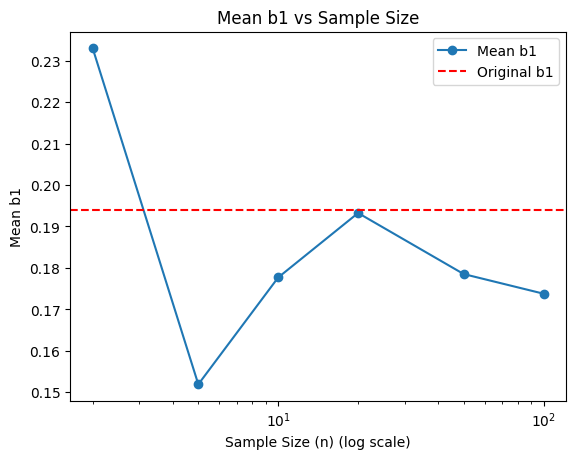

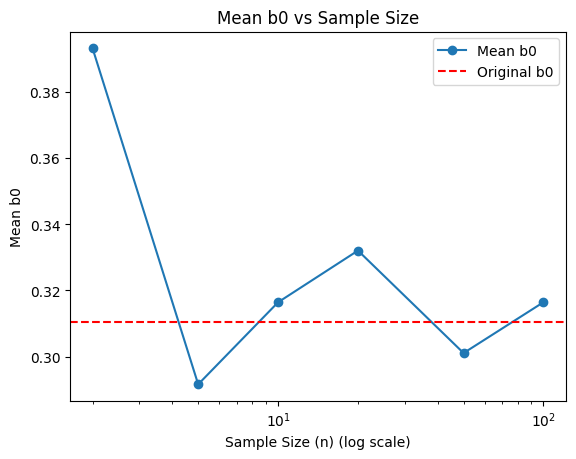

In [25]:
rng = np.random.default_rng(seed=0)

def simulate_XY(n):
    X = rng.normal(size=n)
    eps = rng.normal(size=n)
    Y = rho * X + np.sqrt(1 - rho**2) * eps
    return X, Y

def ols(X, y):
    A = np.column_stack([np.ones(len(X)), X])
    beta_hat, *_ = np.linalg.lstsq(A, y, rcond=None)
    return beta_hat

X0, Y0 = simulate_XY(1000)
ytilde0 = (Y0 >= c).astype(int)
beta_orig = ols(X0, ytilde0)
b0_orig, b1_orig = beta_orig

print(f"Original OLS Coefficients:")
print(f"b0: {b0_orig:.4f}, b1: {b1_orig:.4f}")

N = 100
means = []
for n in n_values:
    betas = np.empty((N, 2))
    for s in range(N):
        X, Y = simulate_XY(n)
        ytilde = (Y >= c).astype(int)
        betas[s] = ols(X, ytilde)
    means.append(betas.mean(axis=0))
means = np.array(means)

plt.plot(n_values, means[:, 1], marker='o', label='Mean b1')
plt.axhline(b1_orig, color='r', linestyle='--', label='Original b1')
plt.xscale('log')
plt.xlabel('Sample Size (n) (log scale)')
plt.ylabel('Mean b1')
plt.title('Mean b1 vs Sample Size')
plt.legend()
plt.show()

plt.plot(n_values, means[:, 0], marker='o', label='Mean b0')
plt.axhline(b0_orig, color='r', linestyle='--', label='Original b0')
plt.xscale('log')
plt.xlabel('Sample Size (n) (log scale)')
plt.ylabel('Mean b0')
plt.title('Mean b0 vs Sample Size')
plt.legend()
plt.show()

We can see that for small $n$, the estimates of $\beta_0, \beta_1$ are pretty
far off. However, as $n$ increases, the value slowly reaches the original model
coefficient. Our results are still a bit noisy as we are only using N = 100 independent
repetitions, but we should see better results if we were to increase the Monte
Carlo simulations.

## e

We can derive what OLS is estiamting via the population linear projection:
$$
(\beta_0, \beta_1) = arg \min E[(\tilde{Y} - b_0 - b_1X)^2]
$$.
We know $E[X] = 0, \quad Var(X) = 1$, thus:
$$
\beta_1 = \frac{Cov(X,\tilde{Y})}{Var(X)} = E[X\tilde{Y}], \quad \beta_0 = E[\tilde{Y}] - \beta_1 E[X] = E[\tilde{Y}]
$$
Because $Y \sim \mathcal{N}(0, 1)$:
$$
\beta_0 = P(Y \geq c) = 1 - \Phi(c) = \Phi(-c) \\
\beta_1 = E[X\tilde{Y}] = E[E[X | Y]\mathbf{1}\{Y \geq c\}] \\
= E[\rho Y \mathbf{1}\{Y \geq c\}] = \rho E[Y \mathbf{1}\{Y \geq c\}]
= \rho \int_c^\infty y\phi(y)dy = \rho\phi(c) \therefore \\
\beta_0 = \Phi(-c) \\
\beta_1 = \rho\phi(c)
$$
As we explained in part (c), the probit curve coefficients differ from these
derived coefficients, consequently the OLS is not targeting these coefficeints
but rather as expected, the best linear approximation. In this sense, the OLS is 
"biased" for the structural / probit coefficeints. However, they are also
biased as exact unbiasedness rquires the general model conditio of $E[e | X] = 0$.
But, because the true mean is nonlinear, the condition fails, and consequently
the finite-sample unbiasedness is not guaranteed. We can also see this as while
we have good estimates using Monte Carlo, they are not guaranteed for all $n$ 
and some values of $n$ are wildly off for the expected coefficient values.

**LLM Usage**: All work was done by myself in VSCode with [GitHub Copilot integration](https://code.visualstudio.com/docs/copilot/overview). The integration "provides code suggestions, explanations, and automated implementations based on natural language prompts and existing code context," and also offers autonomous coding and an in-IDE chat interface that is able to interact with the current codebase. Only the Copilot provided automatic inline suggestions for both LaTex and Python in `.tex` and `.ipynb` Jupyter notebook files respectively were taken into account / used.

**Problem 1**:  
a) LLM was not used in this problem.  
b) LLM was used to help setup efficient loop to run scenarios.  
c) LLM was used to help setup bootstrap and confirm correct calculation of means.  

**Problem 2**:  
a) LLM was used to check the Bernoulli derivation.  
b) LLM helped generate the grid plots to accurately show data.  
c) LLM was consulted on explanation.  
d) LLM helped set up and double check correct calcluation of coefficients.  
e) LLM helped explain how bias applies.